In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from model import *
import random
from mpl_toolkits.mplot3d import Axes3D

First we look at the evolution of MTD for the mean parameters observed in the PCV treatment.

In [3]:
y0_PCV = (1.0, 7.13, 41.2, 0.0) #Initial conditions
parameters_PCV = (0.121, 0.0295, 0.0031, 0.00867, 0.729, 0.729, 0.24, 100) #Parameters lambda_p, k_P_Q, k_Qp_P, delta_Qp, gamma_P, gamma_Q, KDE, K

y0_TMZ = (1.0, 0.924, 42.3, 0.0) #Initial conditions
parameters_TMZ = (0.114, 0.0226, 0.0045, 0.0214, 0.842, 0.842, 0.32, 100)

y0_rad = (1.0, 3.89, 40.3, 0.0)
parameters_rad = (0.138, 0.0249, 0.000001, 0.0125, 1.71, 1.71, 0.317, 100)

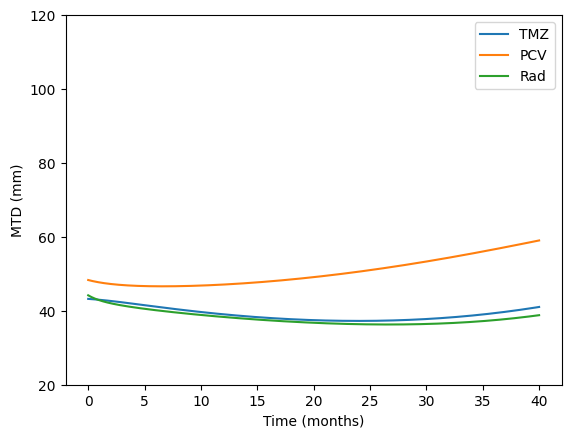

In [4]:
y_TMZ = odeint(derivees, y0_TMZ, np.linspace(0, 40, 400), args=(parameters_TMZ, ))
y_PCV = odeint(derivees, y0_PCV, np.linspace(0, 40, 400), args=(parameters_PCV, ))
y_rad = odeint(derivees, y0_rad, np.linspace(0, 40, 400), args=(parameters_rad, ))



plt.plot(np.linspace(0, 40, 400), y_TMZ[:, 1] + y_TMZ[:, 2] + y_TMZ[:, 3], label='TMZ')
plt.plot(np.linspace(0, 40, 400), y_PCV[:, 1] + y_PCV[:, 2] + y_PCV[:, 3], label='PCV')
plt.plot(np.linspace(0, 40, 400), y_rad[:, 1] + y_rad[:, 2] + y_rad[:, 3], label='Rad')
plt.xlabel('Time (months)')
plt.ylabel('MTD (mm)')
plt.legend()
plt.ylim(20, 120)
plt.show()

3 Parameters are associated to tumors, are Q0, P0 and $\lambda_{P}$. When doing individual prediction, $\lambda_{P}$ is estimated from the patient and the other parameters considered are mean parameters. The MTD is measured at time of treatment and P0 is considered to be 10% of the MTD. (At what size are LGG detected ?)

Lets generate size of tumor (MTD) between 30 and 85 and associate a $\lambda_{P}$. But is $\lambda_{P}$ dependant on size ?

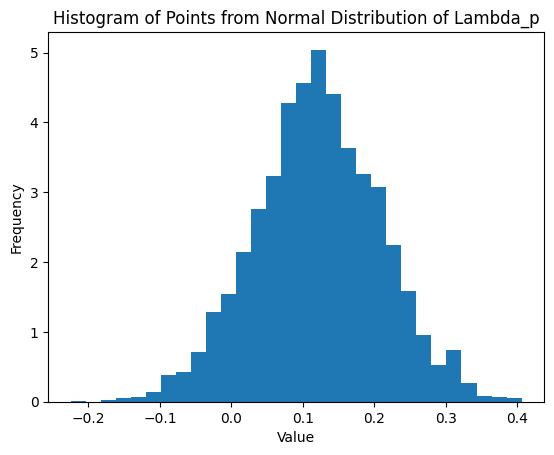

In [11]:
#Distribution of lambda_p with mu = 0.121 and CV = 72%
points = np.random.normal(0.121, 0.121*72/100, size=3000)
plt.hist(points, bins=30, density=True)

plt.title('Histogram of Points from Normal Distribution of Lambda_p')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

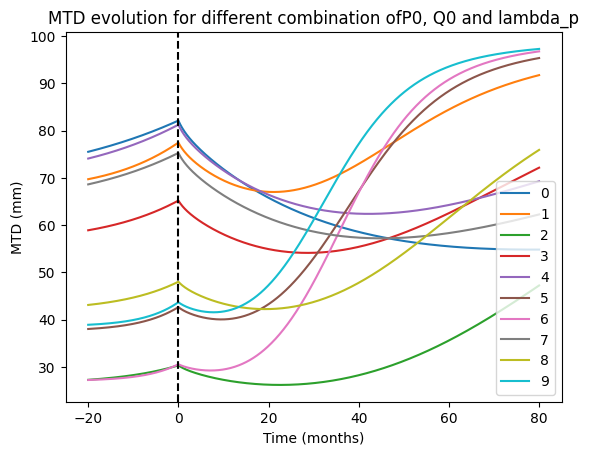

In [6]:
def random_evolution_MTD():
    
    MTD = random.uniform(30, 85)
    P0 = 0.1*MTD
    Q0 = MTD - P0

    value = np.random.normal(0.121, 0.121*72/100)
    if value >= 0:
        lambda_p = value
    else:
        lambda_p = 0
        
    #The other parameters are the one of TMZ
    y0 = (1.0, P0, Q0, 0.0)
    y0_growth = (0.0, P0, Q0, 0.0)
    parameters = (lambda_p, 0.0226, 0.0045, 0.0214, 0.842, 0.842, 0.32, 100)
    parameters_growth = (lambda_p, 0.0226, 100)

    y = odeint(derivees, y0, np.linspace(0, 80, 800), args=(parameters, ))
    y_growth = odeint(growth_no_treatment, y0_growth, np.linspace(0, 20, 200), args=(parameters_growth, ))
    evol = np.concatenate((np.flip(y_growth), y), axis=0)
    return evol, (P0, Q0, lambda_p)

Param = []
for i in range(10):
    evol, param = random_evolution_MTD()
    plt.plot(np.concatenate((np.linspace(-20, 0, 200), np.linspace(0, 80, 800))), evol[:, 1] + evol[:, 2] + evol[:, 3], label = str(i))
    Param += [param]

plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Time (months)')
plt.ylabel('MTD (mm)')
plt.title('MTD evolution for different combination ofP0, Q0 and lambda_p')
plt.legend()
plt.show()

In [5]:
print(Param)

[(6.613288483827685, 59.51959635444916, 0.023971218376710388), (3.7387150278696524, 33.64843525082687, 0.19678493998400337), (3.8381740474601402, 34.54356642714126, 0.13472086144811093), (7.953227809845217, 71.57905028860695, 0.21452245639890088), (7.490034472519923, 67.41031025267931, 0.13452745038930275), (5.794743452442887, 52.152691071985984, 0), (6.215373239477738, 55.938359155299636, 0.2083386017302093), (7.983093964732463, 71.84784568259217, 0.19874828474125422), (5.163155893654916, 46.46840304289424, 0.19864156566153784), (6.4943913452326205, 58.44952210709358, 0.17114569076308314)]


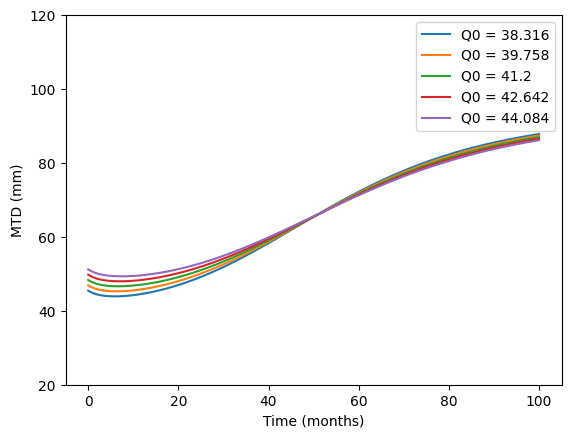

In [30]:

#Testing different initial conditions we make the initial conditions vary according to the interindividuality observed for the PCV

#P0 in [5.35; 8.917] because mean P0 = 7.13 with CV of 94%
    #Q0 in [38.316; 44.084] because mean Q0 = 41.2 with CV of 25%

Y = []
for P0 in np.linspace(5.35, 8.917, 5):
    for Q0 in np.linspace(38.316, 44.084, 5):
        y0 = (1.0, P0, Q0, 0.0)
        y = odeint(derivees, y0, np.linspace(0, 100, 1000), args=(parameters_PCV, ))
        Y += [y]


plt.plot(np.linspace(0, 100, 1000), Y[10][:, 1] + Y[10][:, 2] + Y[10][:, 3], label='Q0 = 38.316') 
plt.plot(np.linspace(0, 100, 1000), Y[11][:, 1] + Y[11][:, 2] + Y[11][:, 3], label='Q0 = 39.758')
plt.plot(np.linspace(0, 100, 1000), Y[12][:, 1] + Y[12][:, 2] + Y[12][:, 3], label='Q0 = 41.2')
plt.plot(np.linspace(0, 100, 1000), Y[13][:, 1] + Y[13][:, 2] + Y[13][:, 3], label='Q0 = 42.642')
plt.plot(np.linspace(0, 100, 1000), Y[14][:, 1] + Y[14][:, 2] + Y[14][:, 3], label='Q0 = 44.084')
plt.ylim(20, 120)
plt.xlabel('Time (months)')
plt.ylabel('MTD (mm)')
plt.legend()
plt.show()



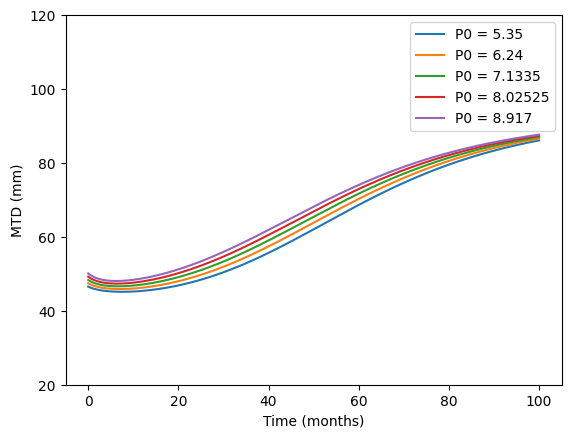

In [31]:
plt.plot(np.linspace(0, 100, 1000), Y[2][:, 1] + Y[2][:, 2] + Y[2][:, 3], label='P0 = 5.35') 
plt.plot(np.linspace(0, 100, 1000), Y[7][:, 1] + Y[7][:, 2] + Y[7][:, 3], label='P0 = 6.24')
plt.plot(np.linspace(0, 100, 1000), Y[12][:, 1] + Y[12][:, 2] + Y[12][:, 3], label='P0 = 7.1335')
plt.plot(np.linspace(0, 100, 1000), Y[17][:, 1] + Y[17][:, 2] + Y[17][:, 3], label='P0 = 8.02525')
plt.plot(np.linspace(0, 100, 1000), Y[22][:, 1] + Y[22][:, 2] + Y[22][:, 3], label='P0 = 8.917')
plt.ylim(20, 120)
plt.xlabel('Time (months)')
plt.ylabel('MTD (mm)')
plt.legend()
plt.show()


We see on the next figure that the bigger the P0 the later the minimum MTD occur. 

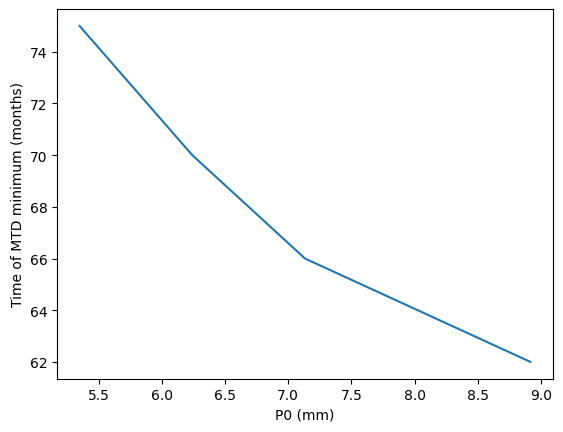

In [12]:
P01 = Y[2][:, 1] + Y[2][:, 2] + Y[2][:, 3]
P02 = Y[7][:, 1] + Y[7][:, 2] + Y[7][:, 3]
P03 = Y[12][:, 1] + Y[12][:, 2] + Y[12][:, 3]
P04 = Y[17][:, 1] + Y[17][:, 2] + Y[17][:, 3]
P05 = Y[22][:, 1] + Y[22][:, 2] + Y[22][:, 3]

min_index = [np.argmin(P01), np.argmin(P02), np.argmin(P03), np.argmin(P04), np.argmin(P05)]


plt.plot(np.linspace(5.35, 8.917, 5), min_index)
plt.xlabel('P0 (mm)')
plt.ylabel('Time of MTD minimum (months)')
plt.show()

In the article, we are given with the mean parameters the CV (Coefficient of variation) in %. $CV = \frac{\sigma}{\mu}$

Here is the 3D phase portrait in function of Q, P and $\lambda_{p}$.

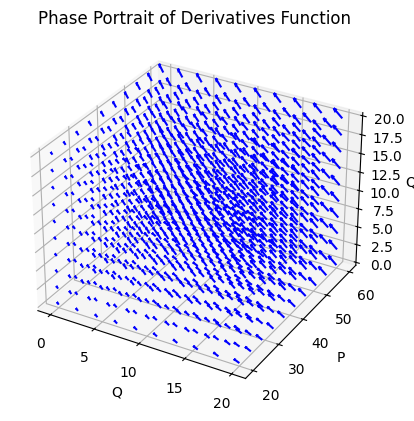

In [ ]:
# Define the parameters
lambda_p = np.linspace(0, 2.5, 9)

Qp = np.linspace(0, 20, 10)
P = np.linspace(0, 20, 10)
Q = np.linspace(20, 60, 10)
P, Q, Qp = np.meshgrid(P, Q, Qp)

parameters_TMZ = (0.114, 0.0226, 0.0045, 0.0214, 0.842, 0.842, 0.32, 100)

# Evaluate the derivatives function on the grid
dC, dP, dQ, dQp = derivees((1.0, P, Q, Qp), 0, parameters_TMZ)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the phase portrait
ax.quiver(P.ravel(), Q.ravel(), Qp.ravel(), dP.ravel(), dQ.ravel(), dQp.ravel(), color='b', length = 0.1)

# Set plot labels and title
ax.set_xlabel('P')
ax.set_ylabel('Q')
ax.set_zlabel('Qp')
ax.set_title('Phase Portrait of Derivatives Function')

# Show the plot
plt.show()

We see that no matter P or Q, given the parameters of the TMZ treatment, we will get a decrease of Q and P and an increase of Qp when C = 1. But this is not always the case for some value of C, P and Q will increase at least when they are equal to the mean values PO Q0. (as we saw on the trajectory we plotted for the mean parameters)
But what 

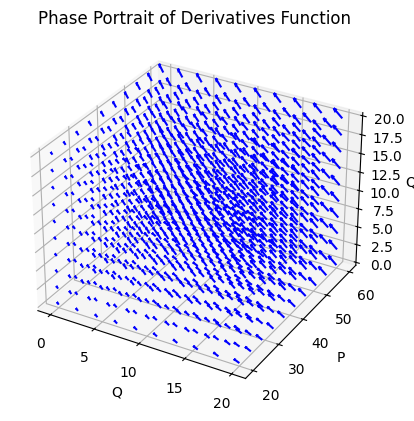

In [ ]:
# Define the parameters
Qp = np.linspace(0, 20, 10)
P = np.linspace(0, 20, 10)
Q = np.linspace(20, 60, 10)
P, Q, Qp = np.meshgrid(P, Q, Qp)

parameters_TMZ = (0.114, 0.0226, 0.0045, 0.0214, 0.842, 0.842, 0.32, 100)

# Evaluate the derivatives function on the grid
dC, dP, dQ, dQp = derivees((1.0, P, Q, Qp), 0, parameters_TMZ)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the phase portrait
ax.quiver(P.ravel(), Q.ravel(), Qp.ravel(), dP.ravel(), dQ.ravel(), dQp.ravel(), color='b', length = 0.1)

# Set plot labels and title
ax.set_xlabel('P')
ax.set_ylabel('Q')
ax.set_zlabel('Qp')
ax.set_title('Phase Portrait of Derivatives Function')

# Show the plot
plt.show()

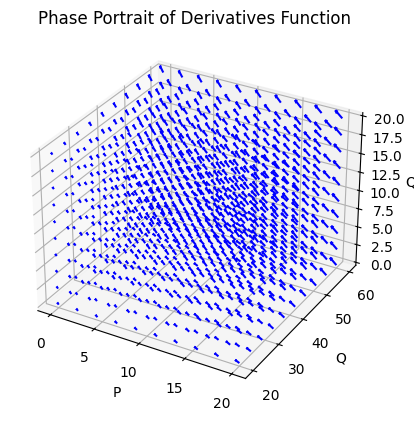

In [32]:
parameters_TMZ = (0.114, 0.0226, 0.0045, 0.0214, 0.842, 0.842, 0.32, 100)
C_values = [1.0, 0.8, 0.6, 0.4, 0.2]


plot_3D_phase_portrait(0.8, parameters_TMZ)

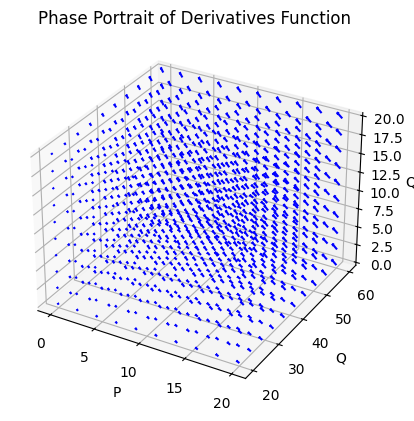

In [31]:
plot_3D_phase_portrait(0.6, parameters_TMZ)

We can suppose that treatment efficacy $\gamma$ will be determinant for the evolution of tumor size. We are going to plot the mean MTD in function of $\frac{\lambda}{\gamma}$.

In [ ]:
from optimisation import *

#Generate a set of data for different values of PO, Q0 and lambda.
#First lets look at the effect of the ratio P0/Q0 on the mean size of the Tumour

Q0 = 40
#We assume P0 will vary in 2% to 15% of Q0

for i in range(0.02, 0.15, 0.02):
    P0 = i*Q0
    